<a href="https://colab.research.google.com/github/muhammad-usama-aleem/Continual-Learning/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **loading dataset**

In [7]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/continual_learning.zip

In [9]:
from google.colab import drive
drive.flush_and_unmount()

In [10]:
import tensorflow as tf

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32

TRAIN_DIR = "/content/train"


train_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15,
    subset='training',
    seed=124,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15,
    subset='validation',
    seed=124,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

class_names = train_data.class_names

In [ ]:
print(class_names)

['army', 'men', 'tanks']


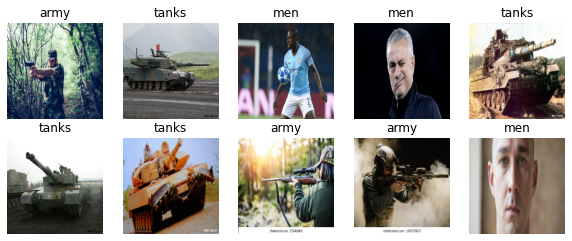

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
inputs = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = img_augmentation(inputs)

In [ ]:
model = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

In [ ]:
# Freeze the pretrained weights
model.trainable = False
# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(5, activation=tf.nn.relu)(x)

outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="pred")(x)

# Compiling

In [ ]:
# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['img_augmentation[0][0]']       
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_3[0][0]'] 

In [ ]:
epochs = 25  
hist = model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


83/83 - 42s - loss: 0.5444 - accuracy: 0.7770 - val_loss: 0.3108 - val_accuracy: 0.9765 - 42s/epoch - 502ms/step
Epoch 2/25
83/83 - 21s - loss: 0.2126 - accuracy: 0.9469 - val_loss: 0.1275 - val_accuracy: 0.9893 - 21s/epoch - 249ms/step
Epoch 3/25
83/83 - 21s - loss: 0.1566 - accuracy: 0.9488 - val_loss: 0.0543 - val_accuracy: 0.9936 - 21s/epoch - 252ms/step
Epoch 4/25
83/83 - 21s - loss: 0.1380 - accuracy: 0.9571 - val_loss: 0.0370 - val_accuracy: 0.9936 - 21s/epoch - 255ms/step
Epoch 5/25
83/83 - 21s - loss: 0.1080 - accuracy: 0.9653 - val_loss: 0.0275 - val_accuracy: 0.9936 - 21s/epoch - 253ms/step
Epoch 6/25
83/83 - 21s - loss: 0.1099 - accuracy: 0.9631 - val_loss: 0.0266 - val_accuracy: 0.9936 - 21s/epoch - 254ms/step
Epoch 7/25
83/83 - 21s - loss: 0.1015 - accuracy: 0.9631 - val_loss: 0.0259 - val_accuracy: 0.9915 - 21s/epoch - 252ms/step
Epoch 8/25
83/83 - 21s - loss: 0.0770 - accuracy: 0.9721 - val_loss: 0.0243 - val_accuracy: 0.9915 - 21s/epoch - 253ms/step
Epoch 9/25
83/83 - 

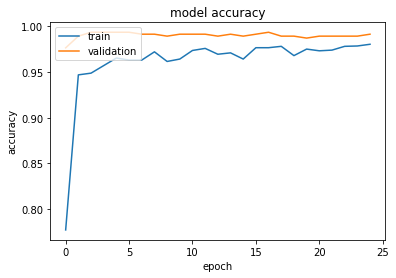

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [ ]:
model.evaluate(val_data)

15/15 [==============================] - 4s 166ms/step - loss: 0.0225 - accuracy: 0.9915


[0.022472454234957695, 0.9914529919624329]

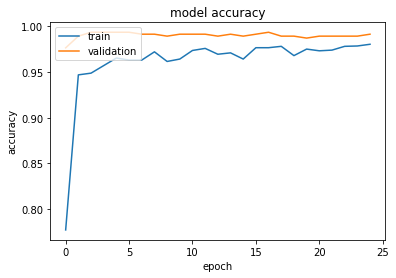

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [ ]:
model.evaluate(val_data)

15/15 [==============================] - 4s 166ms/step - loss: 0.0225 - accuracy: 0.9915


[0.022472454234957695, 0.9914529919624329]

In [ ]:
results = model.predict(val_data)

In [ ]:
# !rm -rf /content/inetlenv

In [ ]:
model.save("inetlenv")

INFO:tensorflow:Assets written to: inetlenv/assets


In [ ]:
!zip -r /content/inetlenv.zip /content/inetlenv/

  adding: content/inetlenv/ (stored 0%)
  adding: content/inetlenv/assets/ (stored 0%)
  adding: content/inetlenv/saved_model.pb (deflated 91%)
  adding: content/inetlenv/variables/ (stored 0%)
  adding: content/inetlenv/variables/variables.index (deflated 76%)
  adding: content/inetlenv/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/inetlenv/keras_metadata.pb (deflated 95%)


In [ ]:
model.save("my_h5_model.h5")

# **Continual Learning**

In [11]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32

TRAIN_DIR = "/content/continual learning"


train_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15,
    subset='training',
    seed=124,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.15,
    subset='validation',
    seed=124,
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = 32
)

class_names = train_data.class_names

Found 2305 files belonging to 4 classes.
Using 1960 files for training.
Found 2305 files belonging to 4 classes.
Using 345 files for validation.


In [12]:
print(class_names)

['army', 'cars', 'men', 'tanks']


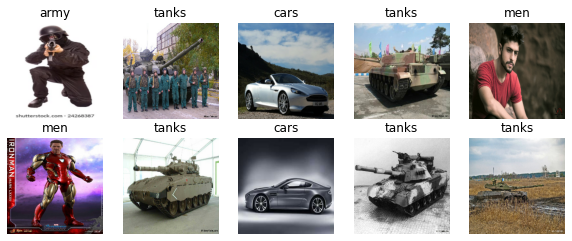

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for images, labels in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model

In [2]:
from tensorflow import keras
import tensorflow as tf


model = keras.models.load_model('/content/my_h5_model.h5')

In [3]:
x= model.layers[-2].output 

In [4]:
outputs = tf.keras.layers.Dense(4, activation="softmax", name="predictions")(x)

In [5]:


model = tf.keras.Model(inputs = model.input, outputs = outputs)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img_augmentation (Sequential)  (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['img_augmentation[0][0]']       
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_3[0][0]']        

In [18]:
# Compile
model = tf.keras.Model(model.input, outputs, name="Continual_learning")
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [19]:
epochs = 25  
hist = model.fit(train_data, epochs=epochs, validation_data=val_data, verbose=2)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


62/62 - 38s - loss: 3.8873 - accuracy: 0.3250 - val_loss: 0.8105 - val_accuracy: 0.7391 - 38s/epoch - 605ms/step
Epoch 2/25
62/62 - 15s - loss: 0.6335 - accuracy: 0.7592 - val_loss: 0.2528 - val_accuracy: 0.8986 - 15s/epoch - 247ms/step
Epoch 3/25
62/62 - 16s - loss: 0.3911 - accuracy: 0.8398 - val_loss: 0.1525 - val_accuracy: 0.9507 - 16s/epoch - 260ms/step
Epoch 4/25
62/62 - 16s - loss: 0.2857 - accuracy: 0.8913 - val_loss: 0.1186 - val_accuracy: 0.9623 - 16s/epoch - 259ms/step
Epoch 5/25
62/62 - 15s - loss: 0.2273 - accuracy: 0.9133 - val_loss: 0.0982 - val_accuracy: 0.9681 - 15s/epoch - 243ms/step
Epoch 6/25
62/62 - 15s - loss: 0.1834 - accuracy: 0.9296 - val_loss: 0.0897 - val_accuracy: 0.9681 - 15s/epoch - 243ms/step
Epoch 7/25
62/62 - 15s - loss: 0.1625 - accuracy: 0.9383 - val_loss: 0.0748 - val_accuracy: 0.9710 - 15s/epoch - 246ms/step
Epoch 8/25
62/62 - 15s - loss: 0.1423 - accuracy: 0.9526 - val_loss: 0.0619 - val_accuracy: 0.9768 - 15s/epoch - 247ms/step
Epoch 9/25
62/62 - 

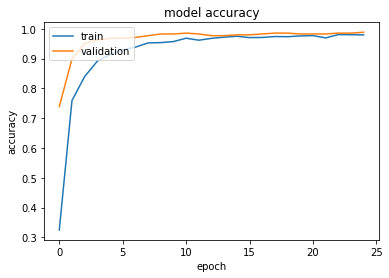

In [20]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [21]:
model.evaluate(val_data)

11/11 [==============================] - 3s 151ms/step - loss: 0.0357 - accuracy: 0.9884


[0.03573423624038696, 0.9884058237075806]

In [23]:
model.save("continual_learning_model.h5")